In [35]:
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter, ListedColormap
import seaborn as sns

#set seaborn plotting style
sns.set_style('darkgrid')

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [36]:
import pandas as pd

#train_features2 = pd.read_csv('dataset1_train_features.csv')
#test_features2 = pd.read_csv('dataset1_test_features.csv')
train_features = pd.read_csv('dataset2_train_features.csv')
test_features = pd.read_csv('dataset2_test_features.csv')

#train_features = pd.concat([train_features, train_features2], ignore_index=True)
#test_features = pd.concat([test_features, test_features2], ignore_index=True)

train_types = []

for row in train_features['Type']:
    if row == 'Class':
        train_types.append(1)
    else :
        train_types.append(0)
        
train_features['Type_encode'] = train_types

test_types = []

for row in test_features['Type']:
    if row == 'Class':
        test_types.append(1)
    else:
        test_types.append(0)
        
test_features['Type_encode'] = test_types

X_train = train_features.loc[:, 'Ngram1_Entity':'Type_encode']
T_train = train_features['Match']
T = np.zeros((T_train.shape[0], 2))
T[np.arange(len(T)), T_train] += 1
T_train = T

X_test = test_features.loc[:, 'Ngram1_Entity':'Type_encode']
T_test = test_features['Match']

T = np.zeros((T_test.shape[0], 2))
T[np.arange(len(T)), T_test] += 1
T_test = T
print(X_test.shape)
X_train = X_train.fillna(value=0)
X_test = X_test.fillna(value=0)
X_train = np.array(X_train)
T_train = np.array(T_train)
X_validation = np.array(X_test[300:])
T_validation = np.array(T_test[300:])
X_test = np.array(X_test[0:300])
T_test = np.array(T_test[0:300])

print(X_test.shape)

(506, 88)
(300, 88)


In [37]:
def logistic(z):
    """Logistic Function"""
    return 1 / (1 + np.exp(-z))

def relu(z):
    """Rectifeid linear unit"""
    return z * (z>0)

def relu_deriv(y):
    """The derivetive of the relu function."""
    return 1. * (y>0)

def logistic_deriv(y):
    return np.multiply( y, (1-y))

def softmax(z):
    """softmax function"""
    return np.exp(z) / np.sum(np.exp(z), axis = 1, keepdims=True)

In [38]:
class Layer(object):
    """Base class for the different layers.
    Define base methods and documentation of methods."""
    
    def get_params_iter(self):
        """Return an iterator over the parameters (if any).
        The iterator has the same order as the get_params_grad.
        The elements returned by the iterator are editable in-place"""
        return []
    
    def get_momentum_iter(self):
        """Return an iterator over the parameters (if any).
        The iterator has the same order as the get_params_grad.
        The elements returned by the iterator are editable in-place"""
        return []
    
    def get_params_grad(self, X, output_grad):
        """Return a list of gradients over the parameters.
        The list has the same order as the get_params_iter iterator.
        X is the input.
        output_grad is the gradient at the output of this layer."""
        return []
    
    def get_output(self, X):
        """Perform the forward setp linear transformation.
        X is the input."""
        pass
    
    def get_input_grad(self, Y, output_grad = None, T = None):
        """Return the grad at the inputs of this layer.
        Y is the precomputed output of this layer(not needed in
        this case).
        output_grad is the gradient at the output of this layer
        (gradient at the next layer inputs).
        output layer uses T to compute the gradient based on the 
        output error instead of output_grad"""
        pass

In [39]:
class LinearLayer(Layer):
    """The linear layer perform a linear transformation to its input."""
    
    def __init__(self, n_in, n_out):
        """Initialize the hidden layer parameters.
        n_in is the number of input variables.
        n_out is the number of the output variables."""
        self.W = np.random.randn(n_in, n_out) * 0.1
        self.M = np.zeros((n_in, n_out))
        self.b = np.zeros((n_out, 1))
        self.Mb = np.zeros((n_out, 1))
        
    def get_params_iter(self):
        """Return an iterator over the parameters."""
        return itertools.chain(
            np.nditer(self.W, op_flags=['readwrite']),
            np.nditer(self.b, op_flags=['readwrite']))
    
    def get_momentum_iter(self):
        return itertools.chain(
            np.nditer(self.M, op_flags=['readwrite']),
            np.nditer(self.Mb, op_flags=['readwrite']))
    
    def get_output(self, X):
        """Perform the forward step linear transformation."""
        return ( X @ self.W ) + self.b.T
    
    def get_params_grad(self, X, output_grad):
        """Return a list of gradients over the parameters."""
        JW = X.T @ output_grad
        Jb = np.sum(output_grad, axis = 0)
        return [g for g in itertools.chain(
            np.nditer(JW), np.nditer(Jb))]
    def get_input_grad(self, Y, output_grad):
        """Return the gadient at the input of this layer."""
        return output_grad @ self.W.T


In [40]:
class LogisticLayer(Layer):
    """The logistic layer apply the logistic function to its inputs."""
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return logistic(X)
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradients at the input of this layer."""
        return np.multiply( logistic_deriv(Y), output_grad)


In [41]:
class ReluLayer(Layer):
    """The Relu layer apply the Relu function to its input."""
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return relu(X)
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradients at the input of this layer."""
        return np.multiply(relu_deriv(Y), output_grad)

In [42]:
class SoftmaxOutputLayer(Layer):
    """The softmax output layer compute the classification
    propabilities at the ouput."""
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return softmax(X)
    
    def get_input_grad(self, Y, T):
        """Return the gradient at the input of this layer."""
        return (Y - T) / Y.shape[0]
    
    def get_cost(self, Y, T):
        """Return the cost at the output of this layer."""
        return - np.multiply(T, np.log(Y)).sum() / Y.shape[0]
    

In [43]:
#Sample model to be trained on the data
hidden_neurons_1 = 30 #number of neurons in the first hidden layer
hidden_neurons_2 = 30 #number of neurons in the second hidden layer
hidden_neurons_3 = 10
hidden_neurons_3 = 10
#Create the model
layers = [] # define a list of layers
#Add the first hidden layer
layers.append(LinearLayer(X_train.shape[1], hidden_neurons_1))
layers.append(ReluLayer())
#Add the second hidden layer
layers.append(LinearLayer(hidden_neurons_1, hidden_neurons_2))
layers.append(ReluLayer())
layers.append(LinearLayer(hidden_neurons_2, hidden_neurons_3))
layers.append(ReluLayer())
#Add the output layer
layers.append(LinearLayer(hidden_neurons_3, T_train.shape[1]))
layers.append(SoftmaxOutputLayer())

In [44]:
#Forward propagation step as method
def forward_step(input_samples, layers):
    """
    
    Compute and returns the forward activation of each layer in layers.
    Input:
        input_samples: A matrix of input samples (each
                            row is an input vector)
        layers : is a list of layers
    Output : 
        A list of activations where the activation at each index
        i+1 corresponeds to the activation of layer i in layers.
        activations[0] contains the input samples. 
        """
    
    activations = [input_samples] # list of layers activations
    #compute the forward activation of each layer starting
    #from the first
    X = input_samples
    for layer in layers:
        #Get the output of the current layer
        Y = layer.get_output(X)
        #Store the output for future processing
        activations.append(Y)
        #Set the current input as the activation of the previous layer
        X = activations[-1]
    return activations

In [45]:
#Define the backward propagation as a method
def backward_step(activations, targets, layers):
    """
    Perform the backpropagation step over all the layers and return the parameters gradients.
    Input :
        activations : A list of forward step activations where the activation at 
        each index i+1 corresponds to the activation of layer i in layers.
        activation[0] containes the input samples.
        targets : The ouput target of the output layer.
        layers : A list of layers that generated the output in actiavtions.
    Output :
        A list of parameter gradients where the gradients at each index corresponds to 
        the parameters gradients at the layer at the same index in layers. 
    """
    
    params_grads = collections.deque() #List of parameters gradients for each layer
    output_grad = None #The error gradient at the output of the current layer
    #Propagate the error backwards throug all the layers.
    #Use reversed to iterate backward throug the list of layers.
    for layer in reversed(layers):
        Y = activations.pop() # Get the activation of the last layer in the stack
        # Compute the error at the output layer
        #The ouput layer is calculated different than hidden layer error.
        if output_grad is None :
            input_grad = layer.get_input_grad(Y, targets)
        else : #output_grad is not None (Layer is not output layer)
            input_grad = layer.get_input_grad(Y, output_grad)
        # Get the input of this layer (activations of the previous layer)
        X = activations[-1]
        #Compute the layer parameters gradients used to update the parameters
        grads = layer.get_params_grad(X, output_grad)
        params_grads.appendleft(grads)
        #Compute gradient at the output of the previous layer (input of current layer)
        output_grad = input_grad
        
    return list(params_grads)

In [46]:
#Create the minibatches
batch_size = 25 # Approximately 25 samples per batch
nb_of_batches = X_train.shape[0] // batch_size # Number of batches

#Create batches (X,Y) from the training set
XT_batches = list(zip(
    np.array_split(X_train, nb_of_batches, axis=0), # X samples
    np.array_split(T_train, nb_of_batches, axis=0) # Y targets
))

In [47]:
def update_momentum(layers, params_grads, momentum_term, learning_rate):
    for layer, layer_backprop_grads in zip(layers, params_grads):
        for momentum, grad in zip(layer.get_momentum_iter(),layer_backprop_grads):
            momentum *= momentum_term 
            momentum += learning_rate * grad

#Define a method to update the parameters
def update_params(layers):
    """
    Function to update the parameters of the given layers with the given
    gradients by gradient descent with the given learning rate."""
    for layer in layers:
        for param, momentum in zip(layer.get_params_iter(),
                               layer.get_momentum_iter()):
            #The parameter returned by the iterator point to the
            #memory space of the original layer and thus can be 
            #modified inplace.
            param -= momentum # Update each parameter
            


In [48]:
#Perform backpropgation
# initialize some lists to store the cost for future analysis
batch_costs = []
train_costs = []
val_costs = []

max_nb_of_iterations =100 # Train for a maximum of 300 iterations
learning_rate = 0.1 # Gradient descent learning rate
momentum_term = 0.9

#Train for the maximum number of iterations
for iteration in range(max_nb_of_iterations):
    for X, T in XT_batches: # For each minibatch sub-iteration
        # Get the activations
        activations = forward_step(X, layers)
        # Get cost
        batch_cost = layers[-1].get_cost(activations[-1], T)
        batch_costs.append(batch_cost)
        #Get the gradients
        params_grads = backward_step(activations, T, layers)
        #update the momentum
        update_momentum(layers, params_grads, momentum_term, learning_rate)
        # Update the parameters
        update_params(layers)
    #Get full training cost for future analysis (plots)
    activations = forward_step(X_train, layers)
    train_cost = layers[-1].get_cost(activations[-1], T_train)
    train_costs.append(train_cost)
    #Get full validation cost
    activations = forward_step(X_validation, layers)
    validation_cost = layers[-1].get_cost(
        activations[-1], T_validation)
    val_costs.append(validation_cost)
    if len(val_costs) > 3 :
        #Stop training if the cost on the validation set doesn't
        # decrease for 3 iterations
        if( val_costs[-1] >= val_costs[-2] >= val_costs[-3]):
            break
    print(f'iter {iteration}')
# The number of iterations that have been excuted
nb_of_iterations = iteration + 1        

iter 0
iter 1
iter 2


In [49]:
#Plot the minibatch, full training set, and validation costs.
batch_x_inds = np.linspace(
    0, nb_of_iterations, num=nb_of_iterations*nb_of_batches)
iteration_x_inds = np.linspace(
    1, nb_of_iterations, num=nb_of_iterations)
#Plot the cost over the iterations
plt.figure(figsize=(6,4))
plt.plot(batch_x_inds, batch_costs, 
        'k-', linewidth=0.5, label='cost minibatches')
plt.plot(iteration_x_inds, train_costs,
        'r-', linewidth=2, label='cost full training set')
plt.plot(iteration_x_inds, val_costs,
        'b-', linewidth=3, label='cost validation set')
#Add labels to the plot
plt.xlabel('iteration')
plt.ylabel('$\\xi$',fontsize=12)
plt.title('Decrease of cost over backprop iteration')
plt.legend()
# x1, x2, y1, y2 = plt.axis()
plt.axis((0, nb_of_iterations, 0, 2.5))
plt.show()


In [50]:
from sklearn import datasets, model_selection, metrics
# Get results of test data
# Get the target outputs
y_true = np.argmax(T_test, axis=1)
print(y_true[:10])
# Get activation of test samples
activations = forward_step(X_test, layers)
# Get the predictions made by the network
y_pred = np.argmax(activations[-1], axis=1)
# Test set accuracy
test_accuracy = metrics.accuracy_score(y_true, y_pred)
print(f'The accuracy on the test set is {test_accuracy:.0%}')

y_true = np.argmax(T_train, axis=1)
# Get activation of train samples
activations = forward_step(X_train, layers)
# Get the predictions made by the network
y_pred = np.argmax(activations[-1], axis=1)
# Train set accuracy
test_accuracy = metrics.accuracy_score(y_true, y_pred)
print(f'The accuracy on the trian set is {test_accuracy:.0%}')


[0 1 1 0 0 0 1 0 1 0]
The accuracy on the test set is 87%
The accuracy on the trian set is 93%


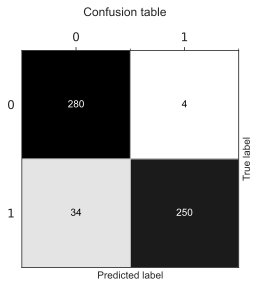

In [51]:
conf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=None)

class_names = [f'${x:d}$' for x in range(0, 10)]
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.xaxis.tick_top()
    major_ticks = range(0, 10)
    minor_ticks = [x + 0.5 for x in range(0, 10)]
    ax.xaxis.set_ticks(major_ticks, minor=False)
    ax.yaxis.set_ticks(major_ticks, minor=False)
    ax.xaxis.set_ticks(minor_ticks, minor=True)
    ax.yaxis.set_ticks(minor_ticks, minor=True)
    ax.xaxis.set_ticklabels(class_names, minor=False, fontsize=12)
    ax.yaxis.set_ticklabels(class_names, minor=False, fontsize=12)
    ax.yaxis.set_label_position("right")
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    fig.suptitle('Confusion table', y=1.03, fontsize=12)
    ax.grid(b=True, which=u'minor')
    ax.imshow(conf_matrix, interpolation='nearest', cmap='binary')
    for x in range(conf_matrix.shape[0]):
        for y in range(conf_matrix.shape[1]):
            color = 'w' if x == y else 'k'
            ax.text(x, y, conf_matrix[y,x], 
                    ha="center", va="center", color=color)
plt.show()